In [4]:
import jax
import jax.numpy as jnp
from ml_collections import config_flags
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ddprism.corrupted_mnist import datasets
from ddprism.corrupted_mnist import metrics
from ddprism.corrupted_mnist import config_downsample_grass
from ddprism.corrupted_mnist import config_downsample_mnist


from pcpca import PCPCA

In [5]:
imagenet_path = ...

## 1. Load grass and MNIST + grass datasets

In [6]:
# Follows from the corresponding lines in the datasets.py file
from einops import rearrange

def get_full_resolution_examples_only(config, obs, labels):
    image_shape = obs.shape[1:]
    # Compute ratios of downsampled examples in a batch
    total = 0
    num_ratios = {}
    for key in config.downsampling_ratios:
        num_ratios[key] = int(config.sample_batch_size * config.downsampling_ratios[key])
        total += int(config.sample_batch_size * config.downsampling_ratios[key])
    num_ratios[list(num_ratios.keys())[0]] += config.sample_batch_size - total

    # Flatten (the images) and add dimension to batch over.
    obs = rearrange( 
                    obs, '(N M) H W C -> N M (H W C)',
                    M=config.sample_batch_size
                )    
    labels = rearrange( 
                    labels, '(N M) -> N M',
                    M=config.sample_batch_size
                )
    # Only take images without downsampling (downsampling ratio = 1)
    obs = obs[:, :num_ratios[1]]
    obs = rearrange(obs, 'N M (H W C) -> (N M) H W C', H=image_shape[0], W=image_shape[1], C=image_shape[2])
    labels = labels[:, :num_ratios[1]]
    labels = rearrange(labels, 'N M -> (N M)',)
    return obs, labels

In [8]:
config_mnist = config_downsample_mnist.get_config()
config_grass = config_downsample_grass.get_config()

### 1.1 Training set

In [9]:
# Generate train dataset with corrupted mnist digits (downsampled + Gaussian noise) 
config = config_mnist

rng = jax.random.key(config.rng_key)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)

# Get our observations, mixing matrix, and covariance.
corrupt_obs, A_mat, cov_y, labels = datasets.get_dataset(
    rng_dataset, 1.0, config.mnist_amp, config.sigma_y,
    config.downsampling_ratios, config.sample_batch_size, imagenet_path,
    config.dataset_size, 
)
# Get subset of the dataset with full resolution images only.
f_train = get_full_resolution_examples_only(config, corrupt_obs, labels)
# Full dataset (both full resolution and downsampled).
f_train_all = (corrupt_obs, labels)

# Train dataset with uncorrupted mnist digits for computing metrics later on.
uncorrupt_obs, A_mat, cov_y, labels = datasets.get_dataset(
        rng_dataset, 0.0, 1.0, config_mnist.sigma_y,
    downsampling_ratios=None, #    config_mnist.downsampling_ratios, 
    sample_batch_size=config_mnist.sample_batch_size, 
    imagenet_path = imagenet_path,
    dataset_size = config_mnist.dataset_size, zeros_and_ones=True,
    )
f_train_uncorrupted = (uncorrupt_obs, labels)


In [12]:
# Generate train dataset with grass (downsampled + Gaussian noise) 
config = config_grass

rng = jax.random.key(config.rng_key)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)

# Get our observations, mixing matrix, and covariance.
corrupt_obs, A_mat, cov_y, labels = datasets.get_dataset(
    rng_dataset, 1.0, 0., config.sigma_y,
    config.downsampling_ratios, config.sample_batch_size, imagenet_path,
    config.dataset_size, 
)


b_train = get_full_resolution_examples_only(config, corrupt_obs, labels)

### 1.2 Validation set

In [13]:
config = config_mnist

# Generate validation dataset with corrupted mnist digits
# Here we take all the observations, including downsampled ones
rng = jax.random.key(config.rng_key_val)
rng_dataset, rng_comp, rng = jax.random.split(rng, 3)

# Get our observations, mixing matrix, and covariance.
corrupt_obs, A_mat, cov_y, labels = datasets.get_dataset(
    rng_dataset, 1.0, config.mnist_amp, config.sigma_y,
    config.downsampling_ratios, 
    sample_batch_size = config.sample_batch_size, 
    imagenet_path = imagenet_path,
    dataset_size=14720, 
)

f_val = (corrupt_obs[config.dataset_size:], labels[config.dataset_size:])

# Uncorrupted validation set
f_val_uncorrupted = datasets.get_corrupted_mnist(
    rng_dataset, grass_amp=0., mnist_amp=1.,
    imagenet_path=imagenet_path,
    dataset_size=14720, 
    zeros_and_ones=True
)
# Take previously unseen digits for the validation set
f_val_images = f_val_uncorrupted[0][config.dataset_size:]
f_val_labels = f_val_uncorrupted[1][config.dataset_size:]
f_val_uncorrupted = (f_val_images, f_val_labels)


## 2. Fit PCPCA

In [14]:
def fit_pcpca(foreground_dataset, background_dataset, gamma=0.385, n_components=2):
    """Fits PCPCA to the foreground and background datasets. 
    Returns:
        pcpca object and mean value of the background dataset.
    """
    # Load foreground and background datasets and flatten images
    X, X_labels = foreground_dataset
    X = X.squeeze(-1).reshape(-1, 784)
    
    Y, Y_labels = background_dataset
    Y = Y.squeeze(-1).reshape(-1, 784)

    # Standardize both X and Y
    Y_mean, Y_std = np.mean(Y, axis=0), np.std(Y, axis=0)
    X = X - Y_mean # Subtract the avg contribution from the background signal
    X_mean, X_std = np.mean(X, axis=0), np.std(X, axis=0)
    
    X = (X - X_mean) / X_std
    Y = (Y - Y_mean) / Y_std

    X, Y = X.T, Y.T
    n = X.shape[1]
    m = Y.shape[1]

    # Fit model
    pcpca = PCPCA(gamma=gamma, n_components=n_components)
    z_X, z_Y = pcpca.fit_transform(X, Y)
    return pcpca, Y_mean

In [15]:
def posterior_samples(rng, dataset, pcpca, background_mean):
    """Computes posterior samples for a given target dataset, given a pcpca object
    and mean of the background dataset.

        Reference: 
             https://www.cs.toronto.edu/~rsalakhu/STA4273_2015/notes/Lecture8_2015.pdf, slide 24
        Returns:
            Posterior samples z ~ p(z|x), posterior mean z_post, and posterior variance sigma2_post.
    
    """
    # Load foreground and background datasets and flatten images
    X, X_labels = dataset
    X = X.squeeze(-1).reshape(-1, 784)

    X = X - background_mean  # Subtract the avg contribution from the background signal
    # Standardize the data
    X_mean, X_std = np.mean(X, axis=0), np.std(X, axis=0)
    X = (X - X_mean)/X_std
    X = X.T
    
    M = pcpca.W_mle.T @ pcpca.W_mle + pcpca.sigma2_mle * np.eye(pcpca.k)
    z_post = np.linalg.inv(M) @ pcpca.W_mle.T @ X
    sigma2_post = pcpca.sigma2_mle * np.linalg.inv(M)

    # Compute posterior samples
    z_post_draws = jax.random.multivariate_normal(rng, mean=z_post.T, cov=sigma2_post,)
    
    post_samples = jnp.matmul(pcpca.W_mle, z_post_draws[..., None])[..., 0]
    post_samples = post_samples *X_std[None, :] + X_mean[None, :]
    post_samples = post_samples.reshape(-1, 28, 28, 1)
    
    
    return post_samples, z_post, sigma2_post 

In [26]:
gamma=0.3
n_components=2
pcpca, background_mean = fit_pcpca(f_train, b_train, gamma=gamma, n_components=n_components)

# Draw posterior samples for the training set.
rng, _ = jax.random.split(rng)
post_samples_train, z_post_train, sigma2_post_train  = posterior_samples(rng, f_train_all, pcpca, background_mean)

# Draw posterior samples for the validation set.
rng, _ = jax.random.split(rng)
post_samples_val, z_post_val, sigma2_post_val = posterior_samples(rng, f_val, pcpca, background_mean)


## 5. Compute metrics on the training and validatin sets

In [ ]:
# Load classifier model to compute FCD
from orbax.checkpoint import CheckpointManager, PyTreeCheckpointer
from pathlib import Path

workdir=Path(...)
checkpointer = PyTreeCheckpointer()
checkpoint_manager = CheckpointManager(workdir, checkpointer
    )

model = metrics.CNN()
params = checkpoint_manager.restore(checkpoint_manager.latest_step())['params'] 
checkpoint_manager.close()

In [27]:
# Compute metrics on the training set.
print('Training set')

n_draws = 10
fcd = []

for _n in range(n_draws):
    rng, _ = jax.random.split(rng)
    post_samples_train, z_post_train, sigma2_post_train  = posterior_samples(rng, f_train_all, pcpca, background_mean)
    # Normalize inferred posterior samples by the amplitude of MNIST digits.
    imgs = post_samples_train / config_mnist.mnist_amp
    fcd.append(metrics.fcd_mnist(model, params, f_train_uncorrupted[0], imgs))
    print(f'Posterior Samples: FCD = {fcd[-1]:.4f}')
    
print(f'\n FCD: {np.array(fcd).mean():.4f} \pm {np.array(fcd).std():.4f}')


Training set
Posterior Samples: FCD = 74.5124
Posterior Samples: FCD = 74.2303
Posterior Samples: FCD = 74.5499
Posterior Samples: FCD = 74.3422
Posterior Samples: FCD = 74.2170
Posterior Samples: FCD = 74.1640
Posterior Samples: FCD = 74.2234
Posterior Samples: FCD = 74.2250
Posterior Samples: FCD = 74.2786
Posterior Samples: FCD = 74.2727

 FCD: 74.3016 \pm 0.1234


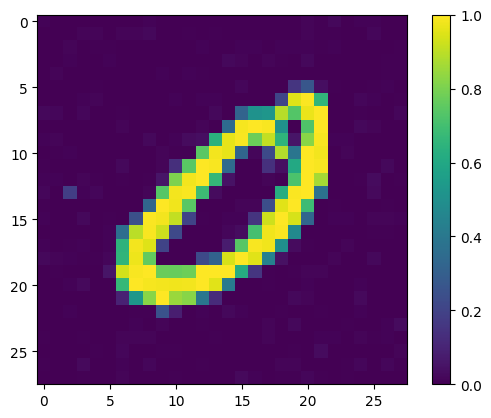

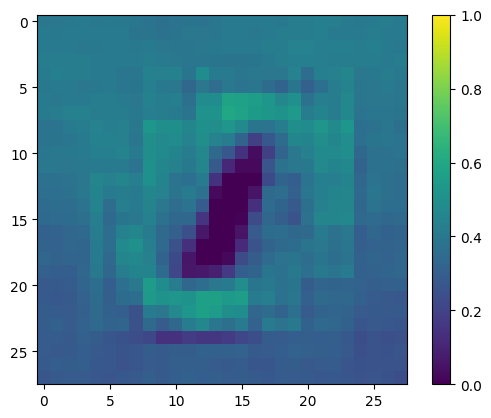

In [28]:
# Compare the true uncorrupted digits with draws from the posterior.
idx = 122
plt.figure(1)
plt.imshow(f_train_uncorrupted[0][idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

plt.figure(2)
plt.imshow(imgs[idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

In [29]:
# Compute metrics on the vslidation set set
print('\nValidation set')

n_draws = 10
fcd = []

post_samples_val_draws = []

for _n in range(n_draws):
    rng, _ = jax.random.split(rng)
    post_samples_val, z_post_val, sigma2_post_val  = posterior_samples(rng, f_val, pcpca, background_mean)
    # Normalize inferred posterior samples by the amplitude of MNIST digits.
    post_samples_val = post_samples_val /  config_mnist.mnist_amp
    post_samples_val_draws.append(post_samples_val)

    fcd.append(metrics.fcd_mnist(model, params, f_val_uncorrupted[0], post_samples_val))
    print(f'Posterior Samples: FCD = {fcd[-1]:.4f}')

print(f'\n FCD: {np.array(fcd).mean():.4f} \pm {np.array(fcd).std():.4f}')



Validation set
Posterior Samples: FCD = 84.7166
Posterior Samples: FCD = 85.3357
Posterior Samples: FCD = 84.7167
Posterior Samples: FCD = 84.6165
Posterior Samples: FCD = 84.5562
Posterior Samples: FCD = 84.2572
Posterior Samples: FCD = 82.9687
Posterior Samples: FCD = 85.1997
Posterior Samples: FCD = 83.4870
Posterior Samples: FCD = 85.3024

 FCD: 84.5157 \pm 0.7328


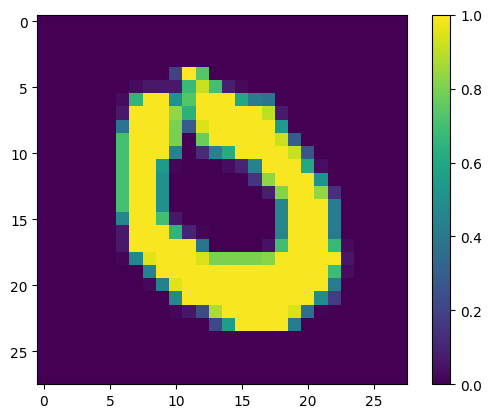

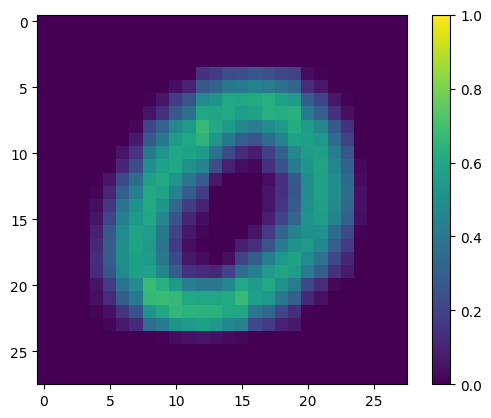

In [23]:
# Compare the true uncorrupted digits with draws from the posterior.
idx = 90
plt.figure(1)
plt.imshow(f_val_uncorrupted[0][idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()


plt.figure(2)
plt.imshow(imgs[idx, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

## Draw samples from the prior

In [24]:
X, X_labels = f_train
X = X.squeeze(-1).reshape(-1, 784)
X = X - background_mean
X_mean, X_std = np.mean(X, axis=0), np.std(X, axis=0)

# Compute posterior samples
num_samples = 10_000
z_draws = jax.random.multivariate_normal(rng, mean=jnp.zeros((num_samples, n_components)), cov=jnp.eye(n_components))
    
prior_samples = jnp.matmul(pcpca.W_mle, z_draws[..., None])[..., 0]
prior_samples = prior_samples * X_std[None, :] + X_mean[None, :]
prior_samples = prior_samples.reshape(-1, 28, 28, 1) / config_mnist.mnist_amp
prior_samples.shape

(10000, 28, 28, 1)

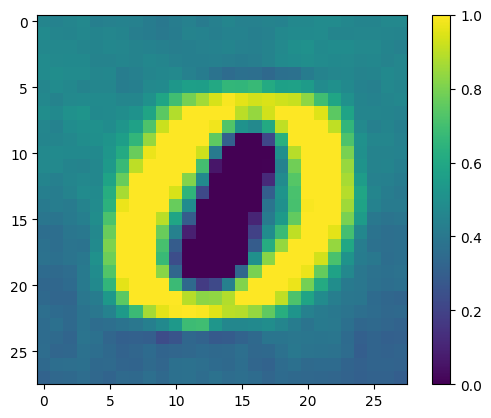

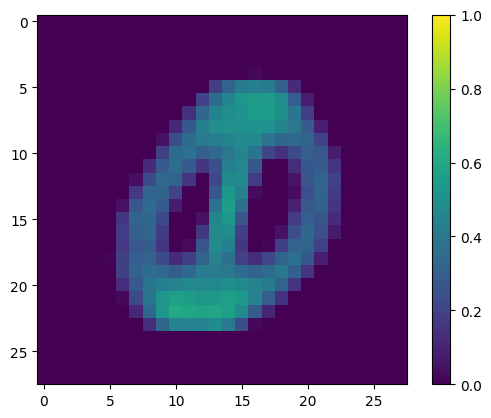

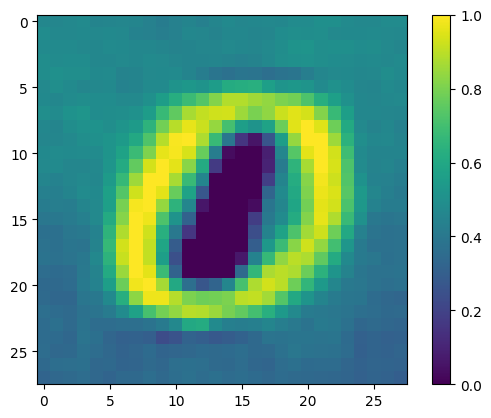

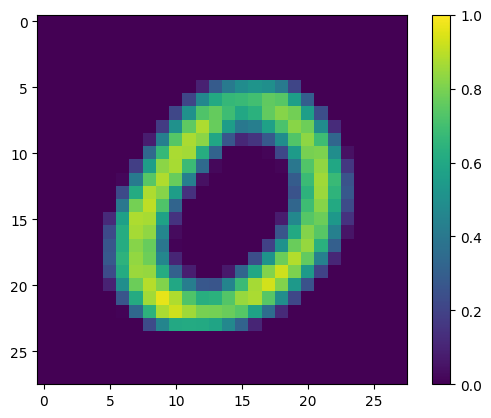

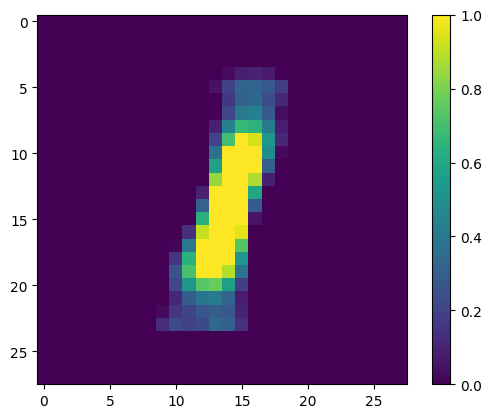

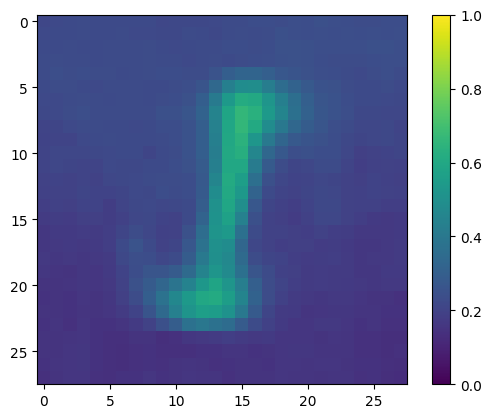

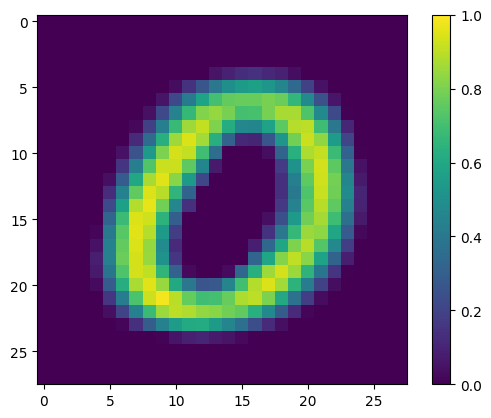

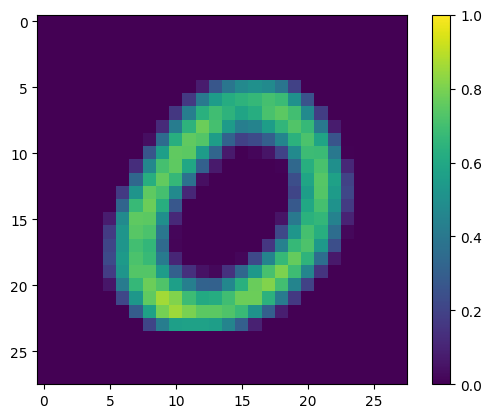

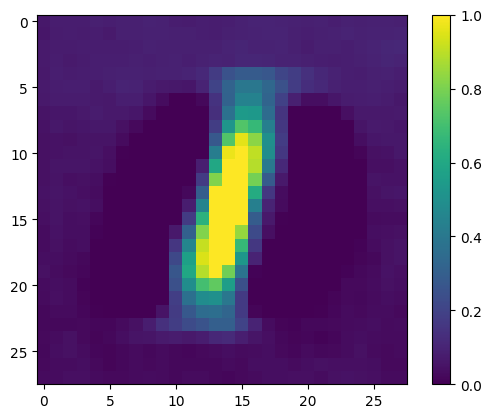

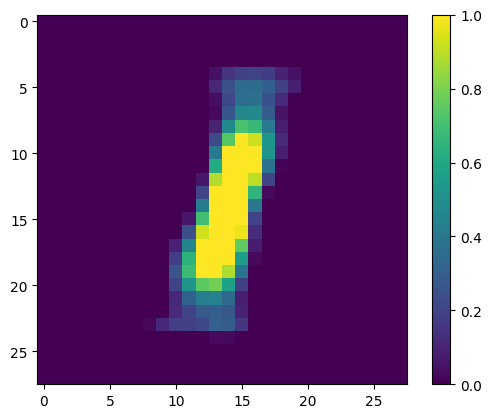

In [25]:
# Visualize prior samples.
for i in range(10):
    plt.figure(i)
    plt.imshow(prior_samples[i, :, :, 0], vmin=0, vmax=1)
    plt.colorbar()